In [31]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import statsmodels.api as sm
import scipy.stats as stats 
from scipy.stats import norm, skew, probplot
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.decomposition import PCA

In [32]:
from Feat_eng import (Y_train, X_train, Y_test, X_test, 
    c1_train, c2_train, c3_train, c1_test, c2_test, c3_test, 
    Y_c1train, Y_c2train, Y_c3train, Y_c1test, Y_c2test ,Y_c3test, zil_yr)

In [33]:
# could we use the zil_yr from original feature engineering?
zri_yr = zil_yr
zri_yr

,RegionName,year,value
1,01013,2011,990.916667
2,01013,2012,943.416667
3,01013,2013,923.583333
4,01013,2014,936.083333
5,01013,2015,962.166667
...,...,...,...
20453,99654,2014,1218.545455
20454,99654,2015,1228.000000
20455,99654,2016,1295.083333
20456,99654,2017,1322.083333


In [34]:
# ZORI DF from zillow
zori = pd.read_csv('../data/Zip_ZORI_AllHomesPlusMultifamily_SSA.csv')
zori

,RegionID,RegionName,SizeRank,MsaName,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,...,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08
0,61639,10025,1,"New York, NY",2883.0,2898.0,2913.0,2928.0,2942.0,2957.0,...,2931.0,2929.0,2928.0,2931.0,2935.0,2938.0,2946.0,2953.0,2961.0,2972.0
1,84654,60657,2,"Chicago, IL",1364.0,1369.0,1374.0,1379.0,1384.0,1388.0,...,1548.0,1547.0,1546.0,1546.0,1546.0,1546.0,1546.0,1546.0,1546.0,1547.0
2,61637,10023,3,"New York, NY",3004.0,3014.0,3024.0,3033.0,3042.0,3051.0,...,2936.0,2933.0,2931.0,2933.0,2936.0,2938.0,2945.0,2951.0,2958.0,2968.0
3,91982,77494,4,"Houston, TX",1362.0,1359.0,1356.0,1353.0,1350.0,1348.0,...,1358.0,1369.0,1380.0,1391.0,1403.0,1415.0,1427.0,1440.0,1452.0,1465.0
4,84616,60614,5,"Chicago, IL",1669.0,1674.0,1679.0,1683.0,1688.0,1693.0,...,1894.0,1896.0,1899.0,1903.0,1906.0,1910.0,1915.0,1921.0,1926.0,1933.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2165,95039,85701,8456,"Tucson, AZ",NaN,851.0,849.0,847.0,846.0,845.0,...,1156.0,NaN,1174.0,1185.0,1196.0,1206.0,1217.0,1228.0,1239.0,1250.0
2166,84608,60606,8497,"Chicago, IL",1978.0,1977.0,1976.0,1975.0,1975.0,1974.0,...,2005.0,2008.0,2012.0,2018.0,2024.0,2031.0,2040.0,2050.0,2059.0,2072.0
2167,61620,10006,8506,"New York, NY",2986.0,3002.0,3017.0,3032.0,3048.0,3064.0,...,2885.0,2872.0,2860.0,2854.0,2849.0,2843.0,2843.0,2843.0,2843.0,2847.0
2168,58623,2109,8792,"Boston, MA",NaN,2932.0,NaN,2946.0,2953.0,2959.0,...,3010.0,3010.0,3009.0,3013.0,3016.0,3020.0,3027.0,3033.0,3040.0,3049.0


In [40]:
# converting zip column (RegionName) to string and filling with 0s
zori['RegionName'] = zori['RegionName'].astype(str).str.zfill(5)

# flattening monthly rent indices
cols_replace = list(zori.columns)[4:]
cols_keep = list(zori.columns)[:4]
zori_new = zori.melt(id_vars=cols_keep, value_vars = cols_replace)

# converting month column to datetime object and pulling year
zori_new['variable']= pd.to_datetime(zori_new['variable'])
zori_new['year'] = zori_new['variable'].apply(lambda a: a.year)

# grouping by year column and calculating mean
zori_yr = zori_new.groupby(['RegionName', 'year']).mean().reset_index()

# dropping non used columns
zori_yr.drop(['SizeRank','RegionID'], inplace=True, axis=1)

In [41]:
# zori_tot - zori data from all years
zori_tot = zori_yr.copy()

In [75]:
zri_yr[zri_yr['RegionName']== '01604']

,RegionName,year,value
210,01604,2011,954.714286
211,01604,2012,1004.250000
212,01604,2013,1066.833333
213,01604,2014,1117.333333
214,01604,2015,1136.333333
215,01604,2016,1197.333333
216,01604,2017,1241.750000
217,01604,2018,1311.833333


In [76]:
zori_yr[zori_yr['RegionName']== '01604']

,RegionName,year,value
0,01604,2014,1087.000000
1,01604,2015,1153.583333
2,01604,2016,1220.666667
3,01604,2017,1284.250000
4,01604,2018,1359.416667
5,01604,2019,1442.583333
6,01604,2020,1522.250000
7,01604,2021,1641.125000


In [50]:
zori_yr

,RegionName,year,value
0,01604,2014,1087.000000
1,01604,2015,1153.583333
2,01604,2016,1220.666667
3,01604,2017,1284.250000
4,01604,2018,1359.416667
...,...,...,...
17355,99207,2017,1074.000000
17356,99207,2018,1126.000000
17357,99207,2019,1216.583333
17358,99207,2020,1281.363636


In [65]:
print(type(zori_yr['RegionName'].iloc[0]))
print(type(zri_yr['RegionName'].iloc[0]))

<class 'str'>
<class 'str'>


In [66]:
print(type(zori_yr['year'].iloc[0]))
print(type(zri_yr['year'].iloc[0]))

<class 'str'>
<class 'str'>


In [218]:
zri_yr

,RegionName,year,value
1,01013,2011,990.916667
2,01013,2012,943.416667
3,01013,2013,923.583333
4,01013,2014,936.083333
5,01013,2015,962.166667
...,...,...,...
20453,99654,2014,1218.545455
20454,99654,2015,1228.000000
20455,99654,2016,1295.083333
20456,99654,2017,1322.083333


In [219]:
zori_yr

,RegionName,year,value
0,01604,2014,1087.000000
1,01604,2015,1153.583333
2,01604,2016,1220.666667
3,01604,2017,1284.250000
4,01604,2018,1359.416667
...,...,...,...
17355,99207,2017,1074.000000
17356,99207,2018,1126.000000
17357,99207,2019,1216.583333
17358,99207,2020,1281.363636


In [226]:
# all zori indices (left join) mapped to zip/year with or without zri indices
df_comb = zori_yr.merge(zri_yr, how='left',
              left_on = ['RegionName', 'year'], 
              right_on = ['RegionName', 'year'])
df_comb.columns = ['RegionName', 'year', 'zori', 'zri']
df_comb

,RegionName,year,zori,zri
0,01604,2014,1087.000000,1117.333333
1,01604,2015,1153.583333,1136.333333
2,01604,2016,1220.666667,1197.333333
3,01604,2017,1284.250000,1241.750000
4,01604,2018,1359.416667,1311.833333
...,...,...,...,...
17355,99207,2017,1074.000000,903.272727
17356,99207,2018,1126.000000,965.166667
17357,99207,2019,1216.583333,NaN
17358,99207,2020,1281.363636,NaN


In [227]:
df_comb.isnull().sum()

RegionName        0
year              0
zori              0
zri           13401
dtype: int64

In [272]:
# outer join of zori_yr and zri_year (more results than zori_yr left join)
df_comb2 = zori_yr.merge(zri_yr, how='outer',
              left_on = ['RegionName', 'year'], 
              right_on = ['RegionName', 'year'])
df_comb2.columns = ['RegionName', 'year', 'zori', 'zri']
df_comb2

,RegionName,year,zori,zri
0,01604,2014,1087.000000,1117.333333
1,01604,2015,1153.583333,1136.333333
2,01604,2016,1220.666667,1197.333333
3,01604,2017,1284.250000,1241.750000
4,01604,2018,1359.416667,1311.833333
...,...,...,...,...
23735,99654,2014,NaN,1218.545455
23736,99654,2015,NaN,1228.000000
23737,99654,2016,NaN,1295.083333
23738,99654,2017,NaN,1322.083333


In [317]:
# filtering zip codes we need 2019, 2020, and 2021 ZRI values for
zri_regs = zri_yr['RegionName'].unique().tolist()
len(zri_regs)
zri_yr.RegionName.nunique()

1652

In [310]:
df_comb2_reg = df_comb2[df_comb2['RegionName'].isin(zri_regs)]

In [331]:
# zori indices for 2019, 2020, and 2021 for the zip codes we have in our dataset
yrs_2 = [2019, 2020, 2021]
df_comb2_reg = df_comb2_reg[df_comb2_reg['year'].isin(yrs_2)]
df_comb2_reg.RegionName.nunique()

861

In [333]:
# same as above -  confirming we only have zori scores for 861 of 1652 total zip codes
zori_reg = zori_yr[zori_yr['RegionName'].isin(zri_regs)]
zori_reg_yr = zori_reg[zori_reg['year'].isin(yrs_2)]
zori_reg_yr.RegionName.nunique()

861

### Predicting ZRI with ZORI

In [336]:
df_comb_red = df_comb.dropna()
df_comb_red

,RegionName,year,zori,zri
0,01604,2014,1087.000000,1117.333333
1,01604,2015,1153.583333,1136.333333
2,01604,2016,1220.666667,1197.333333
3,01604,2017,1284.250000,1241.750000
4,01604,2018,1359.416667,1311.833333
...,...,...,...,...
17352,99207,2014,929.900000,731.818182
17353,99207,2015,966.750000,791.666667
17354,99207,2016,1022.900000,769.125000
17355,99207,2017,1074.000000,903.272727


Text(0, 0.5, 'ZORI')

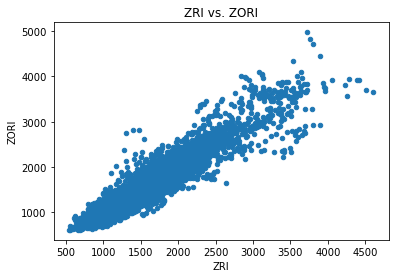

In [338]:
df_comb_red.plot(kind='scatter', x='zori', y='zri')
plt.title('ZRI vs. ZORI')
plt.xlabel('ZRI')
plt.ylabel('ZORI')

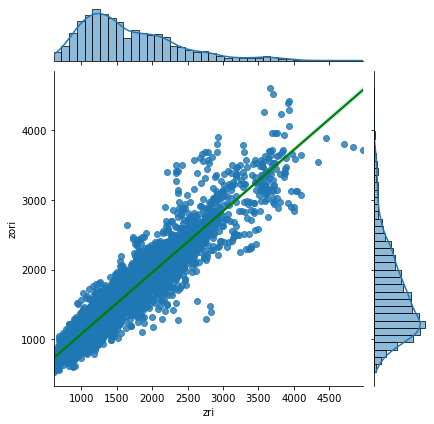

In [339]:
ind_plot = sns.jointplot(x="zri", y="zori", data=df_comb_red, kind='reg')
regline = ind_plot.ax_joint.get_lines()[0]
regline.set_color('green')

<AxesSubplot:>

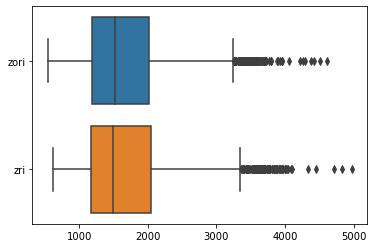

In [340]:
sns.boxplot(data = df_comb_red[['zori', 'zri']], orient = 'h')

### Regression w/ train-test split

In [354]:
X_train, X_test, y_train, y_test = train_test_split(df_comb_red[['zori']], df_comb_red[['zri']], test_size = 0.2)

In [372]:
lm = LinearRegression()
lm.fit(X_train, y_train)
print(f'R-squared: {lm.score(X_train, y_train)}')
print(f'Coefficient: {lm.coef_.item()}')
print(f'Intercept: {lm.intercept_.item()}')

R-squared: 0.875024702400934
Coefficient: 0.9935995089741511
Intercept: 13.902298350427372


In [373]:
pred = lm.predict(X_test)
mse = mean_squared_error(y_test, pred)
RMSE = np.sqrt(mse)
RMSE

239.33016397836198

### Regression w/o train-test split

In [358]:
X = df_comb_red[['zori']]
y = df_comb_red[['zri']]
lm2 = LinearRegression()
lm2.fit(X, y)
print(f'R-squared: {lm2.score(X, y)}')
print(f'Coefficient: {lm2.coef_.item()}')

# similar scores to model w/ train test split

R-squared: 0.8747812596548921
Coefficient: 0.9930531364488863


### Using model to predict ZRI in 2019, 2020, 2021

In [386]:
# predicted ZRI values for 2019, 2020, 2021 - more or less the same as ZORI
zri_pred = lm.predict(df_comb2_reg[['zori']])
df_comb2_reg['zri'] = zri_pred
df_comb2_reg.drop('pred_zri', inplace=True, axis=1)

In [406]:
# adding predicted 2019, 2020, 2021 values to original DF
df_both = df_comb2_reg.dropna()
df_both.drop('zori', inplace=True, axis=1)

In [407]:
df_both

,RegionName,year,zri
5,01604,2019,1447.252390
6,01604,2020,1526.409151
7,01604,2021,1644.523293
13,01702,2019,1827.387002
14,01702,2020,1875.410978
...,...,...,...
17326,98661,2020,1361.968432
17327,98661,2021,1459.713784
17357,99207,2019,1222.698901
17358,99207,2020,1287.064578


In [408]:
zri_yr.columns = ['RegionName', 'year', 'zri']

In [410]:
zri_yr_pred = pd.concat([zri_yr, df_both])
zri_yr_pred

,RegionName,year,zri
1,01013,2011,990.916667
2,01013,2012,943.416667
3,01013,2013,923.583333
4,01013,2014,936.083333
5,01013,2015,962.166667
...,...,...,...
17326,98661,2020,1361.968432
17327,98661,2021,1459.713784
17357,99207,2019,1222.698901
17358,99207,2020,1287.064578


In [411]:
# results are not looking too great - data shows rent indices increased drastically during COVID
zri_yr_pred.groupby(['year']).mean('zri')

,zri
year,
2011,1290.209356
2012,1328.214445
2013,1388.871012
2014,1407.012454
2015,1495.591122
2016,1567.840579
2017,1601.459923
2018,1619.204802
2019,1821.581346
